# DL Indaba Practical 6

# Policy-Gradients with the REINFORCE algorithm
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Background**:
So far we have dealt with supervised learning (each input has a label), and unsupervised learning (we only receive inputs). In this practical we will focus on Reinforcement Learning, which can loosely be defined as "training agents to act in an environments to maximize some reward". We will train an agent using the REINFORCE policy-gradient algorithm to learn to balance a pole in the OpenAI gym [Cartpole environment](https://gym.openai.com/envs/CartPole-v0).

**Learning objectives**:
* Understand how RL differs from supervised and unsupervised learning.
* Understand the policy-gradient approach to directly training a parameterized policy to maximize expected future rewards.
* Understand how the policy-gradient theorem allows us to derive a stochastic gradient estimator on the policy, defined in terms of samples drawn from the very same policy.

**What is expected of you**:
 * Go through the explanation, keeping the above learning objectives in mind. Discuss these with your lab partner.
 * Fill in the missing code ("#IMPLEMENT-ME") and train a model to solve the Cartpole-v0 environment in OpenAI gym (you solve it when reward=200).


# A Simple Policy-Gradient Cartpole Example

## Introduction

There are many different approaches to training RL agents. All of them summarize the environment based on its current **state**, and try to learn how to move from the current state to the next state in order to maximize the **rewards** that the agent will receive over time.

![RL Overview](images/rl_image.png)

One type of approach (value-based) tries to learn the value of being in a current state of the environment. This can be used to direct a guided search function to find the next state to move towards. Another type of approach (policy-based) directly tries to learn what action to take next in order to maximize future rewards. (These can also be combined, with the so-called actor-critic approach). We will focus on policy-based methods in this practical.

Policy-based methods try to learn a policy $\pi_\theta(a | s)$ which outputs a distribution over the possible actions $a$, given the current state $s$ of the environment. The goal is to maximize all expected future rewards, under the learned policy:

\begin{align}
    J(\theta) &= \sum_{t=0}^{T}    \left[ \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\
                        &= \mathbb{E}_{a_t \sim \pi_\theta} \left[ R(s_t, a_t) \right].
\end{align}

Policy-**gradient** methods learn $\pi_\theta$ by directly differentiating this objective function in terms of $\theta$:

\begin{align}
    \nabla_\theta J(\theta) = \sum_{t=0}^{T}    \left[ \nabla_\theta \pi_\theta(a_t|s_t) R(s_t, a_t) \right].
    \end{align}

We want to solve this by sampling actions from our policy and trying these out in the environment. However the current formulation doesn't allow that. But rearranging the identity $\nabla_\theta \log \pi_\theta = \frac{\nabla_\theta \pi_\theta}{\pi_\theta}$ gives us the trick $\nabla_\theta \pi_\theta = \pi_\theta \nabla_\theta \log \pi_\theta$ which we can substitute into the above to get the **[policy-gradient theorem](http://www.scholarpedia.org/article/Policy_gradient_methods)** (also called **[REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)**):

\begin{align}
 \nabla_\theta J(\theta) &= \sum_{t=0}^{T}    \left[ \pi_\theta(a_t|s_t) \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\
 &= \mathbb{E}_{a_t \sim \pi(a|s_t)} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] && \triangleright \textrm{Definition of expections.}
\end{align}

Pause and think about what this means for a second.

**NOTE**: 
* We have a policy $\pi_\theta(a|s)$ which tells the agent which action $a$ to take, given the state $s$, and it is parameterized in terms of parameters $\theta$.
* Our goal $J(\theta)$ is to maximize the rewards the agent receives over time by **choosing actions from this policy** that lead to high future rewards.
* We'll use gradient-based optimization for solving for $\theta$. We therefore want the gradient of our objective wrt the policy parameters (**given actions drawn from our policy**): $\nabla_\theta J(\theta)$.
* We use a simple trick to rearrange this expression for the gradient into an expectation over actions drawn from our policy as it's being learned.
* Since we can now sample actions to take from $a \sim \pi_\theta(a | s)$, we can approximate this gradient using **[Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_integration)** methods:
    \begin{align}
        \nabla_\theta J(\theta) &= \mathbb{E}_{a_t \sim \pi(a|s_t)} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\ 
        &\approx \frac{1}{k} \sum_k \nabla_\theta \log \pi_\theta(a_k|s_t) R(s_t, a_k)
    \end{align}
    
* If our agent parameterizes its actions-distribution as a softmax, then we already know how to do $\nabla_\theta \log \pi_\theta(a_t|s_t)$. It's simply the negative log-likelihood or cross-entropy loss!

This algorithm is called **Monte-Carlo REINFORCE**, and is one type of policy-gradient algorithm. Let's use this to solve the Cartpole environment!




In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.slim as slim    
import gym
from gym.envs.toy_text import discrete
from gym.envs import classic_control
#from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def reset_matplotlib():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

reset_matplotlib()
# for auto-reloading external modules
# (if you're curious, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

try:
    xrange = xrange
except:
    xrange = range
        
env = gym.make('CartPole-v0')


[2017-11-29 14:56:25,032] Making new env: CartPole-v0


## The Policy-based Agent

We begin by parameterizing the policy $\pi_\theta(a | s)$ as a simple neural network which takes the state (a vector of 4 elements provided by `gym`) as input, and produces a softmax over the possible actions as output. Simple enough. 

Next we will write the code to update the model parameters given a reward. For this, we we need to sample an action from the model (policy), try it out in the environment, receive the reward from the environment, and use these together to get an estimate of the gradient wrt the policy. We then update the policy to do better the next time using SGD.

In [2]:
def discount_rewards(r, gamma=0.99):
    """ Take a 1D float array of rewards and compute the discounted reward."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


PM:

1. Takeaway from above re the trick is actually really important. We use the log likelihood derivative trick to convert the gradient of the cost from a summation to a function over a distribution. This makes sampling available to us and we can use Monte Carlo. Very convenient trick! 

2. The algorithm for Monte Carlo explains a lot of what is happening below: 

Input: a differentiable policy parameterization $π(a|s, θ)$ in this case policy is a softmax. 
<br>
Initialize policy parameter $θ ∈ R^{d′}$
<br>
Repeat forever:<br>
    Generate an episode $S_0, A_0, R_1, . . . , S_{T−1}, A_{T−1}, R_T$ , following $π(·|·, θ)$ 
    <br>
    For each step of the episode t = 0, . . . , T − 1:
    <br>
      G ← return from step t
      <br>
      $θ ← θ + α γ^t G ∇_θ ln π(A_t | S_t, θ)$
      
As per the algo, first we generate the full episode, then we process it. 
<br>
The $G_t$ calculation is actually quite complex hence the special function to calculate the discounted reward. 
<br>
Then we actually need to implement this formula: 
\begin{align}
        \nabla_\theta J(\theta) &= \mathbb{E}_{a_t \sim \pi(a|s_t)} \left[ \nabla_\theta \log \pi_\theta(a_t|s_t) R(s_t, a_t) \right] \\ 
        &\approx \frac{1}{k} \sum_k \nabla_\theta \log \pi_\theta(a_k|s_t) R(s_t, a_k)
    \end{align}
    
<br>
For this we need the derivative of the expression: $\log \pi_\theta(a_t|s_t) R(s_t, a_t)$
<br> 
        # Our surrogate loss function:
        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs) * self.reward_holder)
<br>
Derivate of the sum is the sum of the derivatives so next we need to get the derivative of the loss with respect to theta. Theta are the weights from the slim fuly connected layer: 
<br>

        tvars = tf.trainable_variables()

        trainable variables:  [tf.Variable 'fully_connected/weights:0' shape=(4, 2) dtype=float32_ref]

<br>
Gradient is obtained using the tf.gradients() function below. The optimiser is passed the gradients that we manually calculate.  
<br>

        self.gradients = tf.gradients(self.loss, tvars)

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(
                zip(self.gradient_holders, tvars))

<br>
gradients:  [tf.Tensor 'gradients/fully_connected/MatMul_grad/MatMul_1:0' shape=(4, 2) dtype=float32]

In [3]:
class PolicyGradientAgent():
    def __init__(self, lr, state_size, action_size, hidden_size):

        # These lines establish the feed-forward part of the network. 
        # The agent takes a state and produces an action.
        # State:
        self.state_in = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
        
        # IMPLEMENT-ME: Once you've run training and seen how the agent performs:
        # Add a hidden layer of size hidden_size and activation function RELU and see 
        # how the performance of the agent changes

        # pm: Policy: easy way to implement the policy function as a softmax. 
        # pm: Output are state_size x action_size probabilities
        # pm: Compare implementing this in numpy and TF. 
        
        self.output = slim.fully_connected(
                self.state_in, action_size, activation_fn=tf.nn.softmax, biases_initializer=None)

        # The next six lines establish the training procedure. We feed the reward 
        # and chosen action into the network to compute the loss, and use it to 
        # update the network.
        self.reward_holder = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None], dtype=tf.int32)

        # pm: [0] should be state_size? [1] should be action_size? confirm
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(
                self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(
                tf.reshape(self.output, [-1]), self.indexes)
        # reshape [-1] flattens
        # gather collects index slices from params

        # Our surrogate loss function:
        self.loss = -tf.reduce_mean(
                tf.log(self.responsible_outputs) * self.reward_holder)

        tvars = tf.trainable_variables()
        print("trainable variables: ", tvars)
        self.gradient_holders = []
        for idx, var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32, name=str(idx) + '_holder')
            self.gradient_holders.append(placeholder)
        
        # Calculate the gradient of the loss w.r.t. the weights theta from the slim layer
        self.gradients = tf.gradients(self.loss, tvars)
        print("gradients: ", self.gradients)

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(
                zip(self.gradient_holders, tvars))


## Training the agent


In [4]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [12]:
# Clear the Tensorflow graph.
tf.reset_default_graph()    

# Load the agent.
myAgent = PolicyGradientAgent(lr=1e-2, state_size=4, action_size=2, hidden_size=8)    

total_episodes = 2000
max_ep = 999
update_frequency = 5

# Debug flag
dbf = False

init = tf.global_variables_initializer()

frames = {
    0: [],
    500: [],
    1999: []
}

# Launch the tensorflow graph.
with tf.Session() as sess:
    
    sess.run(init)
    i = 0
    total_reward = []
    total_length = []
    mean_rewards = []

    # Get the weights
    gradBuffer = sess.run(tf.trainable_variables())
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    if dbf: print("gradBuffer: ", gradBuffer)
    
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        
        for j in range(max_ep):
    
            # Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output, feed_dict={myAgent.state_in: [s]})
            a = np.random.choice(a_dist[0], p=a_dist[0])
            a = np.argmax(a_dist == a)
            if dbf: print("a_dist: ", a_dist)

            # Get our reward for taking an action given a bandit.
            # env.step(a) takes the proposed action a, runs one step in the environment,
            # and returns the (new state, the reward, boolean done, and information).
            s1, r, d, _ = env.step(a)
            
            if i in frames:
                frames[i].append(env.render(mode = 'rgb_array'))
            
            ep_history.append([s, a, r, s1])
            s = s1
            running_reward += r
            
            # When the episode completes, perform the calculations and make updates
            if d == True:
                
                # Update the network.
                # Calculate the discounted reward: 
                ep_history = np.array(ep_history)
                if dbf: print("reward - before: ", ep_history[:,2])
                ep_history[:, 2] = discount_rewards(ep_history[:, 2])  # in place updates
                if dbf: print("reward - after: ", ep_history[:,2])
                    
                # Prepare the rewards, actions and states for the calculation call: 
                feed_dict = {
                        myAgent.reward_holder: ep_history[:, 2],
                        myAgent.action_holder: ep_history[:, 1],
                        myAgent.state_in: np.vstack(ep_history[:, 0])
                }
                
                # where myAgent.gradients = tf.gradients(myAgent.loss, tvars#weights )
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx, grad in enumerate(grads):
                    gradBuffer[idx] += grad

                # We are updating the theta/weight vaues every 5 episodes: 
                if i > 0 and i % update_frequency == 0:
                    feed_dict = dictionary = dict(
                            zip(myAgent.gradient_holders, gradBuffer))
                    # where update_batch = optimizer.apply_gradients(zip(self.gradient_holders, tvars))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix, grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0

                total_reward.append(running_reward)
                total_length.append(j)
                
                if dbf: 
                    print("s, a, r, s1: ", ep_history)
                    print("a_dist: ", a_dist, " with shape: ", a_dist.shape)
                    print("action_holder: ", ep_history[:,1])
                    print("reward holder: ", ep_history[:,2])
                    indices, resp_outs, tvars = sess.run([myAgent.indexes, myAgent.responsible_outputs, tf.trainable_variables()], feed_dict={
                        myAgent.output: a_dist,
                        myAgent.action_holder: ep_history[:, 1]})
                    print("responsible outputs: ", resp_outs)
                    print("indexes: ", indices)
                    print("weights: ", tvars)
                    
                break

            # Update our running tally of scores.
        if i % 100 == 0:
            mean_reward = np.mean(total_reward[-100:])
            print("Step %d: Mean reward: %.2f" % (i, mean_reward))
            mean_rewards.append((i, mean_reward))
        i += 1
        
print ("FINISHED TRAINING")

trainable variables:  [<tf.Variable 'fully_connected/weights:0' shape=(4, 2) dtype=float32_ref>]
gradients:  [<tf.Tensor 'gradients/fully_connected/MatMul_grad/MatMul_1:0' shape=(4, 2) dtype=float32>]
gradBuffer:  [array([[-0.,  0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0.,  0.]], dtype=float32)]
a_dist:  [[ 0.48252657  0.51747346]]
a_dist:  [[ 0.42486876  0.57513124]]
a_dist:  [[ 0.47746179  0.52253824]]
a_dist:  [[ 0.41930586  0.58069414]]
a_dist:  [[ 0.47107106  0.52892894]]
a_dist:  [[ 0.52310383  0.4768962 ]]
a_dist:  [[ 0.57471466  0.42528525]]
a_dist:  [[ 0.51630819  0.48369178]]
a_dist:  [[ 0.56899089  0.43100905]]
a_dist:  [[ 0.51131499  0.48868498]]
a_dist:  [[ 0.4537006  0.5462994]]
a_dist:  [[ 0.50751257  0.49248743]]
a_dist:  [[ 0.44986391  0.55013609]]
a_dist:  [[ 0.50354862  0.49645147]]
a_dist:  [[ 0.55711931  0.44288075]]
a_dist:  [[ 0.49984404  0.50015593]]
a_dist:  [[ 0.55420011  0.44579983]]
a_dist:  [[ 0.60766608  0.39233389]]
a_dist:  [[ 0.55318266  0.44

/Users/perusha/anaconda/envs/python3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


a_dist:  [[ 0.60304403  0.396956  ]]
a_dist:  [[ 0.55719924  0.44280076]]
a_dist:  [[ 0.51118094  0.48881906]]
a_dist:  [[ 0.46536964  0.53463036]]
a_dist:  [[ 0.52995718  0.47004285]]
a_dist:  [[ 0.48414707  0.51585299]]
a_dist:  [[ 0.54882288  0.45117712]]
a_dist:  [[ 0.50340343  0.49659654]]
a_dist:  [[ 0.5681718  0.4318282]]
a_dist:  [[ 0.52354479  0.47645527]]
a_dist:  [[ 0.47891033  0.52108967]]
a_dist:  [[ 0.54446119  0.45553881]]
a_dist:  [[ 0.4998835   0.50011647]]
a_dist:  [[ 0.45539334  0.54460669]]
a_dist:  [[ 0.52078086  0.47921911]]
a_dist:  [[ 0.47560328  0.52439672]]
a_dist:  [[ 0.43061706  0.56938297]]
a_dist:  [[ 0.49484077  0.50515926]]
a_dist:  [[ 0.5588789   0.44112113]]
a_dist:  [[ 0.5125345  0.4874655]]
a_dist:  [[ 0.57629013  0.42370987]]
a_dist:  [[ 0.63773358  0.36226639]]
a_dist:  [[ 0.69546497  0.304535  ]]
a_dist:  [[ 0.74838465  0.25161532]]
a_dist:  [[ 0.71464884  0.28535113]]
a_dist:  [[ 0.67995036  0.32004964]]
a_dist:  [[ 0.64448702  0.35551298]]
a_dis

/Users/perusha/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/perusha/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[ 0.48525888  0.51474118]]
a_dist:  [[ 0.53173995  0.46826008]]
a_dist:  [[ 0.57789195  0.42210802]]
a_dist:  [[ 0.51499486  0.48500514]]
a_dist:  [[ 0.56263638  0.43736365]]
a_dist:  [[ 0.50031495  0.49968499]]
a_dist:  [[ 0.54913801  0.45086196]]
a_dist:  [[ 0.48740593  0.5125941 ]]
a_dist:  [[ 0.42633355  0.57366639]]
a_dist:  [[ 0.4755165   0.52448356]]
a_dist:  [[ 0.52505934  0.47494066]]
a_dist:  [[ 0.57442683  0.42557314]]
a_dist:  [[ 0.51414102  0.48585892]]
a_dist:  [[ 0.45400527  0.54599476]]
a_dist:  [[ 0.50539953  0.4946005 ]]
a_dist:  [[ 0.44570208  0.55429798]]
a_dist:  [[ 0.49736938  0.50263059]]
a_dist:  [[ 0.43806505  0.56193489]]
a_dist:  [[ 0.48991117  0.5100888 ]]
a_dist:  [[ 0.43095654  0.56904346]]
a_dist:  [[ 0.48289961  0.51710045]]
a_dist:  [[ 0.53532785  0.46467212]]
a_dist:  [[ 0.4767153   0.52328467]]
a_dist:  [[ 0.530195    0.46980509]]
a_dist:  [[ 0.58351052  0.41648942]]
a_dist:  [[ 0.52752239  0.47247767]]
a_dist:  [[ 0.47173706  0.52826291]]
a_dist:  [

s, a, r, s1:  [[array([-0.03597375, -0.04023185,  0.03878274, -0.03721473]) 1
  41.29632180625153
  array([-0.03677838,  0.15431311,  0.03803844, -0.31741347])]
 [array([-0.03677838,  0.15431311,  0.03803844, -0.31741347]) 1
  40.70335535985003
  array([-0.03369212,  0.34887321,  0.03169017, -0.59786191])]
 [array([-0.03369212,  0.34887321,  0.03169017, -0.59786191]) 1
  40.10439935338387
  array([-0.02671466,  0.54353773,  0.01973294, -0.88039673])]
 [array([-0.02671466,  0.54353773,  0.01973294, -0.88039673]) 1
  39.49939328624633
  array([-0.0158439 ,  0.73838612,  0.002125  , -1.16681131])]
 [array([-0.0158439 ,  0.73838612,  0.002125  , -1.16681131]) 1
  38.888276046713464
  array([ -1.07618076e-03,   9.33480356e-01,  -2.12112250e-02,
        -1.45882725e+00])]
 [ array([ -1.07618076e-03,   9.33480356e-01,  -2.12112250e-02,
        -1.45882725e+00])
  0 38.27098590577118
  array([ 0.01759343,  0.73862489, -0.05038777, -1.17284543])]
 [array([ 0.01759343,  0.73862489, -0.05038777, 

action_holder:  [0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1]
reward holder:  [25.282790566840355 24.528071279636723 23.76572856528962 22.995685419484467
 22.21786406008532 21.4321859192781 20.638571635634445 19.8369410460954
 19.027213177874142 18.209306240276913 17.383137616441328 16.54862385499124
 15.705680661607312 14.854222890512437 13.994164535871148 13.12541872310217
 12.247897700103202 11.361512828387072 10.466174574128356 9.561792499119552
 8.64827525163591 7.72553055720799 6.793465209301 5.8519850599 4.90099501
 3.9403989999999998 2.9701 1.99 1.0]
responsible outputs:  [ 0.37539762  0.62460232  0.37539762  0.37539762  0.37539762  0.37539762
  0.62460232  0.62460232  0.62460232  0.62460232  0.37539762  0.62460232
  0.37539762  0.62460232  0.62460232  0.62460232  0.37539762  0.37539762
  0.37539762  0.62460232  0.62460232  0.37539762  0.37539762  0.62460232
  0.62460232  0.62460232  0.62460232  0.37539762  0.62460232]
indexes:  [0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 

s, a, r, s1:  [[array([-0.04050091, -0.04571041,  0.03227203, -0.0006661 ]) 1
  60.332219357797435
  array([-0.04141512,  0.14893421,  0.0322587 , -0.28299467])]
 [array([-0.04141512,  0.14893421,  0.0322587 , -0.28299467]) 0
  59.931534704845895
  array([-0.03843644, -0.04663266,  0.02659881,  0.01968542])]
 [array([-0.03843644, -0.04663266,  0.02659881,  0.01968542]) 0
  59.52680273216757
  array([-0.03936909, -0.24212577,  0.02699252,  0.32064048])]
 [array([-0.03936909, -0.24212577,  0.02699252,  0.32064048]) 0
  59.117982557745016
  array([-0.0442116 , -0.43762151,  0.03340533,  0.62171212])]
 [array([-0.0442116 , -0.43762151,  0.03340533,  0.62171212]) 0
  58.70503288661113
  array([-0.05296404, -0.63319363,  0.04583957,  0.92472597])]
 [array([-0.05296404, -0.63319363,  0.04583957,  0.92472597]) 1
  58.28791200667791
  array([-0.06562791, -0.43871982,  0.06433409,  0.64679379])]
 [array([-0.06562791, -0.43871982,  0.06433409,  0.64679379]) 1
  57.86657778452314
  array([-0.07440

s, a, r, s1:  [[array([ 0.03148894,  0.00257885, -0.02573642, -0.01462787]) 0
  37.01763687967674
  array([ 0.03154052, -0.19216474, -0.02602897,  0.2698251 ])]
 [array([ 0.03154052, -0.19216474, -0.02602897,  0.2698251 ]) 0
  36.38145139361287
  array([ 0.02769723, -0.38690576, -0.02063247,  0.55418604])]
 [array([ 0.02769723, -0.38690576, -0.02063247,  0.55418604]) 1
  35.73883979152815
  array([ 0.01995911, -0.19150026, -0.00954875,  0.25507466])]
 [array([ 0.01995911, -0.19150026, -0.00954875,  0.25507466]) 1
  35.08973716315975
  array([ 0.01612911,  0.00375672, -0.00444726, -0.04060475])]
 [array([ 0.01612911,  0.00375672, -0.00444726, -0.04060475]) 0
  34.4340779425856
  array([ 0.01620424, -0.19130118, -0.00525935,  0.25067171])]
 [array([ 0.01620424, -0.19130118, -0.00525935,  0.25067171]) 0
  33.77179590160162
  array([  1.23782173e-02,  -3.86347635e-01,  -2.45917377e-04,
         5.41691106e-01])]
 [ array([  1.23782173e-02,  -3.86347635e-01,  -2.45917377e-04,
         5.416

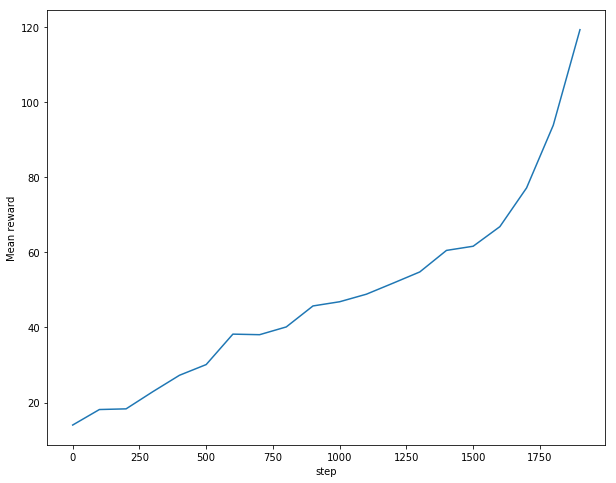

In [7]:

plt.plot(*zip(*mean_rewards))
plt.xlabel('step')
plt.ylabel('Mean reward')





In [ ]:
for i in frames:
    print ("%d-th Episode" % i)
    display_frames_as_gif(frames[i])

# Reference
* Based on this: https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724

# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.